# Basic Stock Trading

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

In [2]:
#define the ticker symbol
tickerSymbol = 'RELIANCE.NS'
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
tickerDf = tickerData.history(interval='1d', start='2019-1-1', end='2020-4-10')

priceData = tickerDf.Open
priceData = priceData.asfreq(pd.infer_freq(priceData.index))
priceData

Date
2019-01-01 00:00:00+05:30    1093.689137
2019-01-02 00:00:00+05:30    1083.240469
2019-01-03 00:00:00+05:30    1076.436708
2019-01-04 00:00:00+05:30    1066.620125
2019-01-05 00:00:00+05:30            NaN
                                ...     
2020-04-05 00:00:00+05:30            NaN
2020-04-06 00:00:00+05:30            NaN
2020-04-07 00:00:00+05:30    1077.120511
2020-04-08 00:00:00+05:30    1153.254681
2020-04-09 00:00:00+05:30    1186.484139
Freq: D, Name: Open, Length: 465, dtype: float64

Text(0.5, 1.0, 'RELIANCE.NS Price Data')

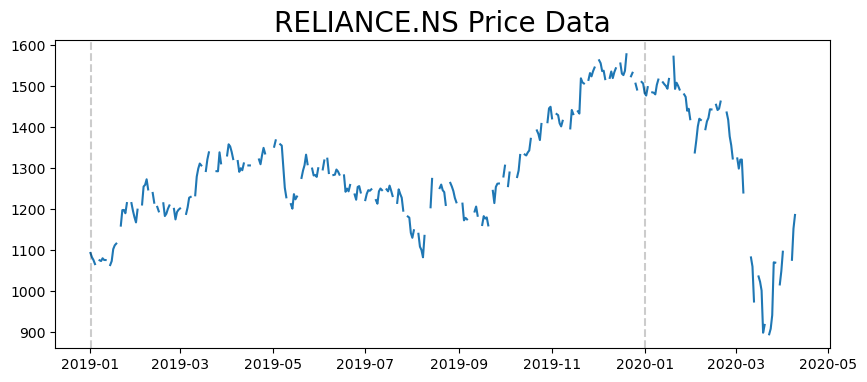

In [3]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

## Basic Buying Protocol:

### - Buy if stock increasing for $b$ consecutive days

## Basic Selling Protocols:

### - Sell if stock decreasing for $s$ consecutive days (and we've made a profit)

In [10]:
def get_buying_selling_days(price_data, b, s):
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    #this function checks the buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    #this function checks the selling condition
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    #get all buying days in the data
    buying_days = pct_change.rolling(b).apply(buying_condition)
    
    #get all potential selling days in the data
    potential_selling_days = pct_change.rolling(s).apply(selling_condition)
    
    #return a dictionary
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [11]:
info_dict = get_buying_selling_days(priceData, 4, 1)

In [12]:
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

In [13]:
#create dataframe to store information
df_stocks = pd.DataFrame(index = buying_days.index)

In [14]:
#populate df with buying days, possible selling days, and price
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = priceData

#only keep days that are buying or possible selling days
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]

In [15]:
df_stocks.head()

,buying_day,potential_selling_day,price
Date,,,
2019-01-02 00:00:00+05:30,False,True,1083.240469
2019-01-03 00:00:00+05:30,False,True,1076.436708
2019-01-04 00:00:00+05:30,False,True,1066.620125
2019-01-08 00:00:00+05:30,False,True,1074.104152
2019-01-10 00:00:00+05:30,False,True,1076.679905


In [16]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]

    return sub_series.product() > 1

In [19]:
def get_investing_result(df_stocks, starting_funds, verbose=False):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date,data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_day:
            
            #calculate the number of shares we can buy
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.potential_selling_day:
            
            #check to make sure we're making a profit
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
    #get the stock price at the end of the time span
    final_stock_price = price_data[-1]
        
    #get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list

In [20]:
percent_change, events_list = get_investing_result(df_stocks, 10000, True)

Bought 8 shares at $1116.578573049173 on 2019-01-18 totaling $8932.63
Sold 8 shares at $1190.6412827452027 on 2019-01-24 totaling $9525.13
--------------------------------------
Bought 8 shares at $1273.5001225959575 on 2019-02-07 totaling $10188.0
Sold 8 shares at $1307.2753940198622 on 2019-03-15 totaling $10458.2
--------------------------------------
Bought 8 shares at $1333.5182573976056 on 2019-05-23 totaling $10668.15
Sold 8 shares at $1384.198826766231 on 2019-10-23 totaling $11073.59
--------------------------------------


In [21]:
print(percent_change)

0.13


(850.0, 1657.0)

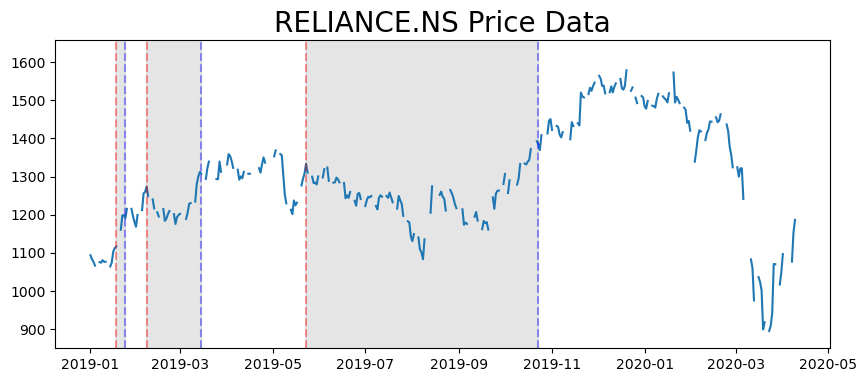

In [22]:
plt.figure(figsize=(10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.ylim(*y_lims)